# The Intuition behind Word2Vec

Have you ever wondered how YouTube knows which videos to recommend, how Google Translate is able to translate whole texts into a decent version of the target language or how your Smartphone keyboard knows which words and text snippets to suggest while you type your texts?

There's a very high likelihood that so-called [Embeddings](https://en.wikipedia.org/wiki/Word_embedding) were used behind the scenes. Embeddings are one of the central ideas behind modern Natural Language Processing models.

In the following writeup we'll discover the main building blocks and basic intuition behind Embeddings. We'll learn how and why they work and how [Word2Vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf), a method to turn words into vectors, can be used to show that:

$$
king - man + woman = queen
$$

All the code we'll write here can be found in my ["Lab"](https://github.com/pmuens/lab) repository on GitHub. Feel free to code along while reading through this tutorial.

## Basic Setup

Before jumping right into the code we need to make sure that all Python packages we'll be using are installed on our machine.

We install [Seaborn](https://seaborn.pydata.org), a visualization tool which helps us to plot nice-looking charts and diagrams. We don't really work with Seaborn directly but rather use its styles in conjunction with [Matplotlib](https://matplotlib.org) to make our plots look a little bit more "modern".

In [1]:
!pip install seaborn

You are using pip version 19.0.2, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Next up we need to import the modules we'll use throughout this tutorial (the last few lines configure Matplotlib to use Seaborn styles).

In [2]:
import json
from pathlib import Path

import pandas as pd
import seaborn as sns
import numpy as np
from IPython.display import HTML, display

# prettier Matplotlib plots
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn')

Since we're dealing with different datasets we should create a separate directory to store them in.

In [3]:
!mkdir -p data
data_dir = Path('data')

## Comparing Countries

Let's start with our first data analysis task. Our goal is to compare and contrast different countries based on their surface area and population. The main idea being that we want to analyze which countries are quite similar and which are rather different based on those two metrics.

The dataset we'll use is part of the [`country-json` project](https://github.com/samayo/country-json) by [@samayo](https://github.com/samayo). Make sure to take some time to browse through the [different JSON files](https://github.com/samayo/country-json/tree/master/src) to get an idea about the structure of the data.

In our example we're only interested in the [`country-by-surface-area.json`](https://github.com/samayo/country-json/blob/master/src/country-by-surface-area.json) and [`country-by-population.json`](https://github.com/samayo/country-json/blob/master/src/country-by-population.json) files. Let's go ahead and download the files to our `data` directory.

After that we can define 2 variables which will point to the files on our file system.

In [4]:
SURFACE_AREA_FILE_NAME = 'country-by-surface-area.json'
POPULATION_FILE_NAME = 'country-by-population.json'

In [5]:
!wget -nc https://raw.githubusercontent.com/samayo/country-json/master/src/country-by-surface-area.json -O data/country-by-surface-area.json
!wget -nc https://raw.githubusercontent.com/samayo/country-json/master/src/country-by-population.json -O data/country-by-population.json

File `data/country-by-surface-area.json' already there; not retrieving.
File `data/country-by-population.json' already there; not retrieving.


In [6]:
surface_area_file_path = str(data_dir / SURFACE_AREA_FILE_NAME)
population_file_path = str(data_dir / POPULATION_FILE_NAME)

During our data analysis we'll utilize [Pandas](https://pandas.pydata.org), a great Python library which makes it dead simple to inspect and manipulate data.

Since our data is in JSON format we can use Pandas [`read_json`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html) function to load the data into a so-called [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) (think of it as an Excel spreadsheet on steroids).

The [`dropna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) function makes sure that we remove all entries which are undefined and therefore useless for further inspection.

In [7]:
df_surface_area = pd.read_json(surface_area_file_path)
df_population = pd.read_json(population_file_path)

df_population.dropna(inplace=True)
df_surface_area.dropna(inplace=True)

You might've noticed that dealing with 2 separate files will get quite hairy if we want to compare countries based on their 2 metrics.

Since both files contain the same countries with the same names and only differ in terms of their `area` and `population` data we can use [`merge`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) to create a new DataFrame containing all countries with their respective `area` and `population` numbers.

Another tweak we perform here is to set the `index` to the country name. This way we can easily query for country data based on the country names rather than having to deal with non-expressive integer values.

In [8]:
df = pd.merge(df_surface_area, df_population, on='country')
df.set_index('country', inplace=True)
df.head()

,area,population
country,,
Aruba,193.0,105264.0
Afghanistan,652090.0,35530081.0
Angola,1246700.0,29784193.0
Anguilla,96.0,14909.0
Albania,28748.0,2930187.0


In [9]:
len(df)

227

As you can see we have a total of 227 countries in our DataFrame. 227 are way too many countries for our need. Especially since we're about to plot the data in the next step.

Let's reduce our result set by perfoming some range-queries with the `area` and `population` data.

In [10]:
df = df[
    (df['area'] > 100000) & (df['area'] < 600000) &
    (df['population'] > 35000000) & (df['population'] < 100000000)
]
len(df)

12

Great! 12 countries are way easier to analyze once plotted.

Speaking of which, let's do a 2D [scatterplot](https://en.wikipedia.org/wiki/Scatter_plot) of our 12 countries. We decide to plot the `area` on the X axis and the `population` on the Y axis.

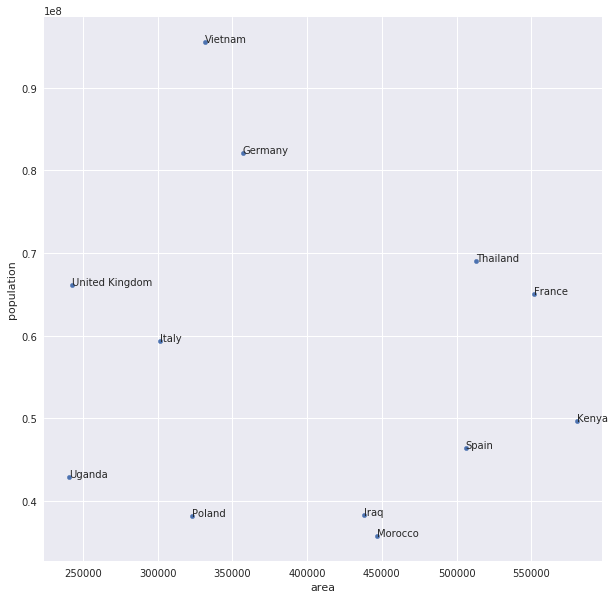

In [11]:
fig, ax = plt.subplots()
df.plot(x='area', y='population', figsize=(10, 10), kind='scatter', ax=ax)

for k, v in df.iterrows():
    ax.annotate(k, v)

fig.canvas.draw()

Looking at the plotted data we can immediately see some relationships. It appears that Vietnam has a high population compared to its area. Kenya on the other hand has a large surface area but a smaller population compared to its size.

Plotting the data like this helps us to reason about it in a visual way. In addition to that we can also easily validate the integrity of our data.

While we as humans can immediately tell the relationships in our country data just by looking at our plot it's necessary to translate our visual reasoning into raw numbers so our computer can understand them too.

Looking at the plot again it seems like the distance between the data points of the countries is a good measure to determine how "similar" or "different" the countries are.

There are several algorithms to calculate the distance between two (or more) coordinates. The [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) is a very common formula to do just that. Here's the Math notation:

$$
d(x, y) = d(y, x) = \sqrt{\sum_{i=1}^N (x_i - y_i)^2}
$$

While the formula might look intimidating at first it's rather simple to turn it into code.

In [12]:
def euclidean_distance(x, y):
    x1, x2 = x
    y1, y2 = y
    result = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    # we'll cast the result into an int which makes it easier to compare
    return int(round(result, 0))

According to our plot it seems like Thailand and Uganda are 2 countries which are very different. Computing the Euclidean distance between both validates our hunch.

In [13]:
# Uganda <--> Thailand
uganda = df.loc['Uganda']
thailand = df.loc['Thailand']

x = (uganda['area'], thailand['area'])
y = (uganda['population'], thailand['population'])

euclidean_distance(x, y)

26175969

If we compare this result to the Eudlidean distance between Iraq and Morocco we can see that those countries seem to be more "similar".

In [14]:
# Iraq <--> Morocco
iraq = df.loc['Iraq']
morocco = df.loc['Morocco']

x = (iraq['area'], morocco['area'])
y = (iraq['population'], morocco['population'])

euclidean_distance(x, y)

2535051

While this exercise was quite simple and intuitive if one is fluent in geography it also introduced us to the basic concepts of Embeddings. With Embeddings we map data (e.g. words or raw numbers) into multi-dimensional spaces and use Math to manipulate and calculate relationships between that data.

This might sound rather abstract and I agree that the relationship between our Country data analysis and Embeddings is still a little bit fuzzy.

Turst me, the upcoming example will definitely result in an "Aha Moment" and suddenly what we've learned so far will click!

## Color Math

Now that we've seen some of the underlying principles of Embeddings let's take another look at a slightly more complicated example. This time we'll work with different colors and their representation as a combination of Red, Green and Blue values (also known as RGB).

Before we jump right into our analysis we'll define a helper function which lets us render the color according to its RGB representation.

The following code defines a function which takes the integer values of Red, Green and Blue (values in the range of 0 - 255) and renders a HTML document with the given color as its background.

In [15]:
def render_color(r, g, b):
    display(HTML('''
      <div style="background-color: rgba(%d, %d, %d, 1); height: 100px;"></div>
    ''' % (r, g, b)),
    metadata=dict(isolated=True))

The color black is represented as 0 Red, 0 Green and 0 Blue. Let's validate that our `render_color` function works as expected.

In [16]:
render_color(0, 0, 0)

Great. It works!

Next up it's time to download the dataset we'll be using for our color analysis. We've decided to use the [256 Colors](https://jonasjacek.github.io/colors/) dataset by [@jonasjacek](https://github.com/jonasjacek). It lists the 256 colors used by [xterm](https://en.wikipedia.org/wiki/Xterm), a widely used terminal emulator. Make sure to take a couple of minutes to familiarize yourself with the data and its structure.

Downloading the dataset follows the same instruction we've used in the beginning of this tutorial where we downloaded the Country data.

In [17]:
COLORS_256_FILE_NAME = 'colors-256.json'

In [18]:
!wget -nc https://jonasjacek.github.io/colors/data.json -O data/colors-256.json

File `data/colors-256.json' already there; not retrieving.


In [19]:
colors_256_file_path = str(data_dir / COLORS_256_FILE_NAME)

Now that we have access to the data in our programming environment it's time to inspect the structure and think about ways to further process it.

In [20]:
color_data = json.loads(open(colors_256_file_path, 'r').read())
color_data[:5]

[{'colorId': 0,
  'hexString': '#000000',
  'rgb': {'r': 0, 'g': 0, 'b': 0},
  'hsl': {'h': 0, 's': 0, 'l': 0},
  'name': 'Black'},
 {'colorId': 1,
  'hexString': '#800000',
  'rgb': {'r': 128, 'g': 0, 'b': 0},
  'hsl': {'h': 0, 's': 100, 'l': 25},
  'name': 'Maroon'},
 {'colorId': 2,
  'hexString': '#008000',
  'rgb': {'r': 0, 'g': 128, 'b': 0},
  'hsl': {'h': 120, 's': 100, 'l': 25},
  'name': 'Green'},
 {'colorId': 3,
  'hexString': '#808000',
  'rgb': {'r': 128, 'g': 128, 'b': 0},
  'hsl': {'h': 60, 's': 100, 'l': 25},
  'name': 'Olive'},
 {'colorId': 4,
  'hexString': '#000080',
  'rgb': {'r': 0, 'g': 0, 'b': 128},
  'hsl': {'h': 240, 's': 100, 'l': 25},
  'name': 'Navy'}]

As we can see there are 3 different color representations available in this dataset. There's a Hexadecimal, a HSL (Hue, Saturation, Lightness) and a RGB (Red, Green, Blue) representation. Furthermore we have access to the name of the color via the `name` attribute.

In our analysis we're only interested in the name and the RGB value of every color. Given that we can create a simple dict which key is the lowercased color name and its value is a tuple containing the Red, Green and Blue values respectively.

In [21]:
colors = dict()

for color in color_data:
    name = color['name'].lower()
    r = color['rgb']['r']
    g = color['rgb']['g']
    b = color['rgb']['b']
    rgb = tuple([r, g, b])
    colors[name] = rgb

To validate that our data structure works the way we described above we can print out some sample colors with their RGB values.

In [22]:
print('Black: %s' % (colors['black'],))
print('White: %s' % (colors['white'],))

print()

print('Red: %s' % (colors['red'],))
print('Lime: %s' % (colors['lime'],))
print('Blue: %s' % (colors['blue'],))

Black: (0, 0, 0)
White: (255, 255, 255)

Red: (255, 0, 0)
Lime: (0, 255, 0)
Blue: (0, 0, 255)


While our dict is a good starting point it's often easier and sometimes faster to do computations on the data if it's stored in a Pandas [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). The [`from_dict`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.from_dict.html) function helps us to turn a simple Python dictionary into a DataFrame.

In [23]:
df = pd.DataFrame.from_dict(colors, orient='index', columns=['r', 'g', 'b'])
df.head()

,r,g,b
black,0,0,0
maroon,128,0,0
green,0,128,0
olive,128,128,0
navy,0,0,128


Seeing the data formatted in this way we can think of its representation as a mapping of the Red, Green and Blue values into a 3-Dimensional space where for example Red is the X axis, Green is the Y axis and Blue is the Z axis.

You might recall that we've used [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) in our Country example above to determine how "similar" countries are. The main idea was that similar countries have less distance between their data points compared to dissimilar countries whose data points are farther apart.

Another very useful formula to calculate the similarity of data points is the so-called [Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). The Cosine similarity measures the angle between two vectors in a multi-dimensional space. The smaller the angle, the more similar the underlying data.

Translating this to our color example we can think of every color being represented as a vector with 3 values (Red, Green and Blue) which (as stated above) can be mapped to the X, Y and Z axis in a 3D coordinate system. Using the Cosine similarity we can take one of such vectors and calculate the distance between it and the rest of the vectors to determine how similar or dissimilar they are. And that's exactly what we'll be doing here.

The Math notation for the Cosine similarity looks like this:

$$
similarity = \cos(\Theta) = \frac{A \cdot B}{\left\lVert A\right\rVert \left\lVert B\right\rVert}
$$

We're taking the [dot-product](https://en.wikipedia.org/wiki/Dot_product) between the two vectors A and B and divide it by the product of their [magnitudes](https://en.wikipedia.org/wiki/Magnitude_(mathematics)#Euclidean_vector_space).

The following code-snippet implements such formula. Again, it might look intimidating and rather complicated but if you take some time to read through it you'll see that it's not that hard to understand.

In fact our implementation here does more than just calculating the Cosine similarity. In addition to that we copy our DataFrame containing the colors and add another column to it which will include the distance as a value between 0 and 1. Once done we sort our copied DataFrame by such distance in descending order. We do this to see the computed values when querying for similar colors later on.

In [24]:
def similar(df, coord, n=10):
    # turning our RGB values (3D coordinates) into a numpy array
    v1 = np.array(coord, dtype=np.float64)
    
    df_copy = df.copy()

    # looping through our DataFrame to calculate the distance for every color
    for i in df_copy.index:
        item = df_copy.loc[i]
        v2 = np.array([item.r, item.g, item.b], dtype=np.float64)
        # cosine similarty calculation starts here
        theta_sum = np.dot(v1, v2)
        theta_den = np.linalg.norm(v1) * np.linalg.norm(v2)
        # check if we're trying to divide by 0
        if theta_den == 0:
            theta = None
        else:
            theta = theta_sum / theta_den
        # adding the `distance` column with the result of our computation
        df_copy.at[i, 'distance'] = theta
    # sorting the resulting DataFrame by distance
    df_copy.sort_values(by='distance', axis=0, ascending=False, inplace=True)
    return df_copy.head(n)

To validate that our `similar` function works we can use it to find similar colors to `red`.

In [25]:
similar(df, colors['red'])

,r,g,b,distance
maroon,128,0,0,1.000000
red3,215,0,0,1.000000
red1,255,0,0,1.000000
darkred,135,0,0,1.000000
red,255,0,0,1.000000
orangered1,255,95,0,0.937082
deeppink2,255,0,95,0.937082
darkorange3,215,95,0,0.914687
darkorange,255,135,0,0.883788
deeppink4,175,0,95,0.878853


We can also pass in colors as a list of RGB values.

In [26]:
similar(df, [100, 20, 120])

,r,g,b,distance
darkviolet,175,0,215,0.991837
darkmagenta,135,0,175,0.991199
magenta1,255,0,255,0.987829
magenta3,215,0,215,0.987829
fuchsia,255,0,255,0.987829
mediumorchid1,255,95,255,0.987592
purple,175,0,255,0.987590
orchid,215,95,215,0.980753
mediumorchid,175,95,215,0.979443
magenta2,255,0,215,0.976656


Since it's hard to imagine what color `100`, `20` and `120` represent it's worthwhile to use our `render_color` function to see it.

In [27]:
render_color(100, 20, 120)

Looking at the list of most similar colors from above it appears that `darkviolet` is quite similar to `100`, `20`, `120`. Let's see how this color looks like.

In [28]:
darkviolet = df.loc['darkviolet']
render_color(darkviolet.r, darkviolet.g, darkviolet.b)

And we can validate that `darkviolet` in fact looks quite similar to `100`, `20`, `120`!

But it doesn't end here. Our 3 color values are numbers in the range of 0 - 255. Given that, it should be possible to do some basic Math computations such as addition or subtraction on them.

Since we only have access to 256 different colors it's highly unlikely that our resulting color values for Red, Green and Blue will exactly match one of our 256 colors. That's where our `similar` function comes in handy! The `similar` function should make it possible to calculate a new color and find its most similar representation in our 256 color dataset.

We can look at a [Color Wheel](https://www.sessions.edu/color-calculator/) to see that subtracintg a `red` color from `purple` one should result in a Blueish color. Let's do the Math and check whether that's true.

In [29]:
blueish = df.loc['purple'] - df.loc['red']

similar(df, blueish)

,r,g,b,distance
darkblue,0,0,135,0.954146
navyblue,0,0,95,0.954146
navy,0,0,128,0.954146
blue3,0,0,215,0.954146
blue1,0,0,255,0.954146
blue,0,0,255,0.954146
dodgerblue2,0,95,255,0.894114
dodgerblue3,0,95,215,0.872745
dodgerblue1,0,135,255,0.843263
deepskyblue4,0,95,175,0.838555


And sure enough the most similar colors in our dataset are Blueish ones. We can validate that by rendering `darkblue`, one of the best matches.

In [30]:
darkblue = df.loc['darkblue']
render_color(darkblue.r, darkblue.g, darkblue.b)

Here's a simple one. If we have Black and add some White to the mix we should get something Greyish, correct?

In [31]:
greyish = df.loc['black'] + df.loc['white']

similar(df, greyish)

,r,g,b,distance
grey93,238,238,238,1.0
grey50,128,128,128,1.0
grey84,215,215,215,1.0
grey53,135,135,135,1.0
grey100,255,255,255,1.0
grey3,8,8,8,1.0
grey7,18,18,18,1.0
grey11,28,28,28,1.0
grey15,38,38,38,1.0
grey19,48,48,48,1.0


And sure enough we do. Rendering `grey93` shows a light grey color.

In [32]:
grey93 = df.loc['grey93']
render_color(grey93.r, grey93.g, grey93.b)

Let's end our color exploration with a more complex formula. So far we've only done some very simple Math like subtracting and adding colors. But there's more we can do. We can also express our search for a color as a "solve for x" problem.

Mixing Yellow and Red will result in Orange. We can translate this behavior to other colors as well. Here we ask "Yellow is to Red as X is to Blue" and express it in Math notation to get the result for X.

In [33]:
# yellow is to red as X is to blue
yellow_to_red = df.loc['yellow'] - df.loc['red']
X = yellow_to_red + df.loc['blue']

similar(df, X)

,r,g,b,distance
lightseagreen,0,175,175,1.000000
turquoise4,0,135,135,1.000000
darkturquoise,0,215,215,1.000000
teal,0,128,128,1.000000
cyan1,0,255,255,1.000000
aqua,0,255,255,1.000000
turquoise2,0,215,255,0.996398
cyan2,0,255,215,0.996398
deepskyblue2,0,175,215,0.994781
cyan3,0,215,175,0.994781


Our calculation shows us that `lightseargreen` is to Blue as Yellow is to Red. Intuitively that makes sense if you think about it.

In [34]:
lightseagreen = df.loc['lightseagreen']
render_color(lightseagreen.r, lightseagreen.g, lightseagreen.b)

## Word2Vec

In the beginnig of this tutorial I promised that once done we should understand the intuition behind [Word2Vec](https://en.wikipedia.org/wiki/Word2vec), a key component for modern Natural Language Processing models.

The `Word2Vec` model does to words what we did with our colors represented as RGB values. It maps words into a multi-dimensional space (our colors were mapped into a 3D space). Once such words are mapped into that space we can perform Math calculations on their vectors the same way we e.g. calculated the similarity between our color vectors.

Having a mapping of words into such a vector space makes it possible to do calculations resulting in:

$$
king - man + woman = queen
$$

## Conclusion

In this tutorial we took a deep dive into the main building blocks and intuitions behind Embeddings, a powerful concept which is heavily utilized in modern Natural Language Processing models.

The main idea is to map data into a multi-dimensional space so that Math calculations from the realm of [Linear Algebra](https://en.wikipedia.org/wiki/Linear_algebra) can be performed on it.

We started our journey with a simple example in which we mapped the surface area and population of different countries into a 2D vector space. We then used the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) to verify that certain countries are similar while others are dissimilar based on their metrics.

Another, more advanced example mapped colors and their RGB representation into a 3D vector space. We then used [Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) and some basic Math to add and subtract colors.

With this knowledge we're now able to understand how more advanced models such as [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) or [Doc2Vec](https://cs.stanford.edu/~quocle/paragraph_vector.pdf) make it possible to do calculations on words and texts.

Do you have any questions / feedback? Feel free to reach out to me via E-Mail or Twitter!

## The Lab

You can find more code examples, experiments and tutorials in my GitHub [Lab](https://github.com/pmuens/lab) repository.

## Additional Resources

Eager to learn more? Here's a list with all the resources I've used to write this post.

- [Allison Parrish - Understanding word vectors](https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469)
- [Jay Alammar - The Illustrated Word2Vec](https://jalammar.github.io/illustrated-word2vec/)
- [Derek Chia - A line-by-line implemenation of Word2Vec](https://towardsdatascience.com/an-implementation-guide-to-word2vec-using-numpy-and-google-sheets-13445eebd281)
- [Skymind.ai - A Beginners Guide to Word2Vec](https://skymind.ai/wiki/word2vec)
- [Word2Vec Paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
- [Doc2Vec Paper](https://cs.stanford.edu/~quocle/paragraph_vector.pdf)